In [10]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

In [2]:
class PricingEnvironment:
    def __init__(self):
        pass

    def round(self, p_t, v_t):
        d_t = 1 if v_t >= p_t else 0
        r_t = p_t*d_t
        return d_t, r_t

In [6]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

    def get_val(self):
        return np.random.uniform(0,1)    

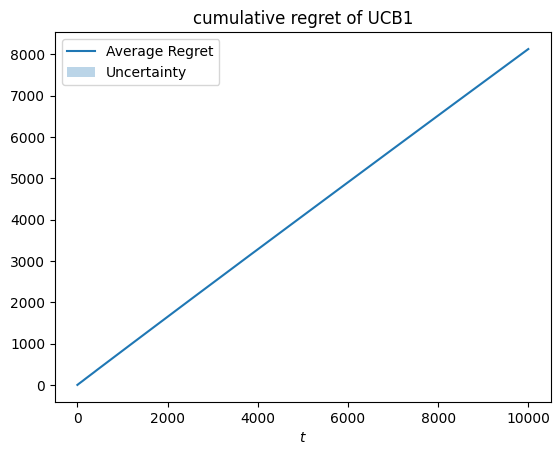

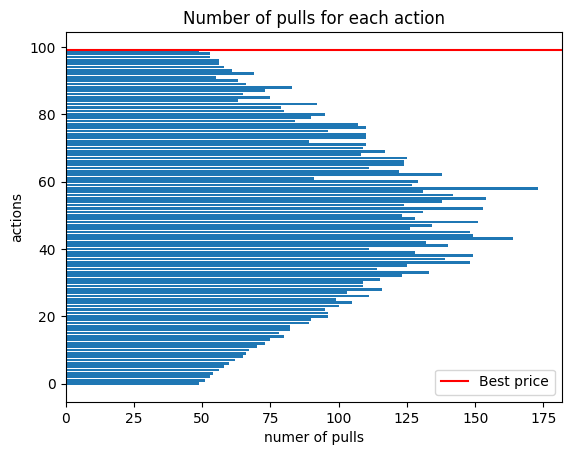

In [9]:
T = 10000 # try T=100, why this behavior?
K = 100

prices = np.linspace(0,1,K) # 100 actions!

n_customers = 1 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: price*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
profit_curve = reward_function(prices, n_customers)
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment()
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        v_t = ucb_agent.get_val()
        d_t, r_t = env.round(p_t, v_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

In [11]:
class PricingEnvironment:
    def __init__(self):
        pass

    def round(self, p_t, v_t):
        d_t = 1 if v_t >= p_t else 0
        r_t = p_t*d_t
        c_t = d_t
        return d_t, r_t, c_t

In [20]:
class UCB1Agent:
    def __init__(self, K, T, B, prices, range=1):
        self.K = K
        self.T = T
        self.B = B
        self.rho = B/T
        self.range = range
        self.prices = prices
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.average_cost = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
        self.v_t = np.random.uniform(0,1)
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucb = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcb = self.average_cost - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.where(prices == self.compute_price(f_ucb, c_lcb))
        return self.a_t
    
    def update(self, r_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.average_cost[self.a_t] += (c_t - self.average_cost[self.a_t])/self.N_pulls[self.a_t]
        self.B -= c_t
        self.t += 1

    def compute_price(self, f_ucb, c_lcb):
        c = -f_ucb

        # Constraints: c_lcb ⋅ γ ≤ rho
        A_ub = [c_lcb]
        b_ub = [self.rho]

        # Sum of γ = 1
        A_eq = [np.ones(len(f_ucb))]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        return np.random.choice(prices, p=res.x)

In [21]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions
def baseline(T, B, v_t, prices):
    rho = B/T

    # simple scenario: competitors sample bids from a uniform 
    # I assume that competitors may have a larger budget than mine, but they may
    # not deplete it.
    v_t = np.random.uniform(0,1)

    ### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
    win_probabilities = [1 if prices[i]<= v_t else 0 for i in range(len(prices))]  

    ## Linear Program
    c = -prices*win_probabilities
    A_ub = [prices*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = [-res.fun for u in range(T)]
    expected_clairvoyant_bids = [sum(prices*gamma*win_probabilities) for u in range(T)]
    return expected_clairvoyant_utilities, expected_clairvoyant_bids

In [25]:
T = 10000 # try T=100, why this behavior?
K = 100
B = 10000
prices = np.linspace(0,1,K) # 100 actions!
n_epochs = 50
all_regrets = []
all_payments = []
for i in range(n_epochs):
    agent = UCB1Agent(K, T, B, prices)
    env = PricingEnvironment()
    expected_clairvoyant_utilities, expected_clairvoyant_bids = baseline(T, B, agent.v_t, prices)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(T):
        # interaction
        pi_t = agent.pull_arm()
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t, c_t = env.round(p_t, agent.v_t)
        agent.update(r_t, c_t)
        if agent.B < 1:
            break

        # logging
        utilities = np.append(utilities, r_t)
        my_bids = np.append(my_bids, p_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

KeyboardInterrupt: 

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_35208\4140476847.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


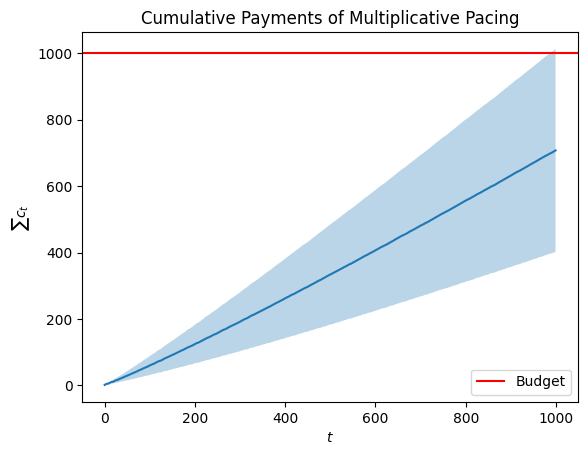

In [23]:
plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\digio\AppData\Local\Temp\ipykernel_35208\1164528170.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


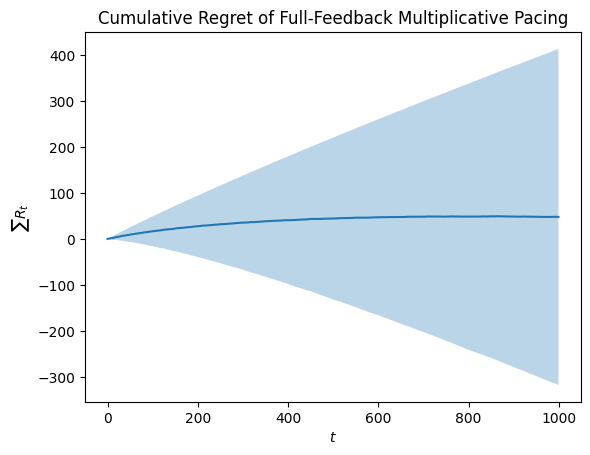

In [24]:
plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()